# Description

The notebook contains checks that compare the prod system output vs that of the prod simulation run ensuring basic sanity.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os

import pandas as pd

import core.config as cconfig
import core.finance.target_position_df_processing as cftpdp
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms as oms
import reconciliation as reconcil

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-a96d3b05-ed55-4053-ac05-d9b6788cf093.json'
INFO  # Git
  branch_name='CmTask6964_Add_only_warning_to_get_system_log_paths'
  hash='9c6e4b652'
  # Last commits:
    *   9c6e4b652 Sameep Pote Merge branch 'master' into CmTask6964_Add_only_warning_to_get_system_log_paths ( 9 minutes ago) Thu Feb 1 22:20:03 2024  (HEAD -> CmTask6964_Add_only_warning_to_get_system_log_paths, origin/CmTask6964_Add_only_warning_to_get_system_log_paths)
    |\  
    * | d02a60629 Sameep2808 nits                                                              (10 minutes ago) Thu Feb 1 22:19:39 2024           
    * | b8806f01b Sameep2808 Fixing test cases                                                 (17 minutes ago) Thu Feb 1 22:12:02 2024           
# Machine info
  system=Linux
  node name=ca8e7dd1b33b
  release=5.15.0-1051-aws
  version=#56~20.04.1-Ubuntu SMP Tue Nov 28 15:43:31 UTC 2023
  machi

# Build the reconciliation config

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
# in the system reconciliation flow.
config = cconfig.get_config_from_env()
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    dst_root_dir = "/shared_data/ecs/preprod/prod_reconciliation/"
    dag_builder_ctor_as_str = (
        "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp"
    )
    start_timestamp_as_str = "20231103_131000"
    end_timestamp_as_str = "20231104_130500"
    run_mode = "paper_trading"
    mode = "scheduled"
    set_config_values = None
    config_list = reconcil.build_reconciliation_configs(
        dst_root_dir,
        dag_builder_ctor_as_str,
        start_timestamp_as_str,
        end_timestamp_as_str,
        run_mode,
        mode,
        set_config_values=set_config_values,
    )
    config = config_list[0]
print(config)

INFO  Using hardwired config
INFO  run_date='20240112'
INFO  Using run_date=20240112
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation/', dag_builder_name='C11a', run_mode='paper_trading', start_timestamp_as_str='20240112_133000', end_timestamp_as_str='20240113_130000'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  system_log_dir='system_log_dir.scheduled'
meta: 
  date_str: 20240112
  asset_class: crypto
  run_tca: False
  bar_duration: 30T
  compute_research_portfolio_mode: automatic
  compute_dag_memory_stats: automatic
system_log_path: 
  prod: /shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/prod/system_log_dir.scheduled
  sim: /shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/simulation/system_log_dir.scheduled
dag_builder_ctor_as_str: dataflow_lemonade.

# Specify data to load

In [5]:
# The dict points to `system_log_dir` for different experiments.
system_log_path_dict = dict(config["system_log_path"].to_dict())

In [6]:
# This dict points to `system_log_dir/dag/node_io/node_io.data` for different experiments.
data_type = "dag_data"
dag_path_dict = reconcil.get_system_log_paths(
    system_log_path_dict, data_type, only_warning=True
)
dag_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/prod/system_log_dir.scheduled/dag/node_io/node_io.data',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/simulation/system_log_dir.scheduled/dag/node_io/node_io.data'}

In [7]:
# This dict points to `system_log_dir/process_forecasts/portfolio` for different experiments.
data_type = "portfolio"
portfolio_path_dict = reconcil.get_system_log_paths(
    system_log_path_dict, data_type
)
portfolio_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/prod/system_log_dir.scheduled/process_forecasts/portfolio',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/simulation/system_log_dir.scheduled/process_forecasts/portfolio'}

In [8]:
# This dict points to `system_log_dir/process_forecasts/orders` for different experiments.
data_type = "orders"
orders_path_dict = reconcil.get_system_log_paths(system_log_path_dict, data_type)
orders_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/prod/system_log_dir.scheduled/process_forecasts/orders',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/simulation/system_log_dir.scheduled/process_forecasts/orders'}

In [9]:
# TODO(gp): Load the TCA data for crypto.
if config["meta"]["run_tca"]:
    tca_csv = os.path.join(
        root_dir, config["meta"]["date_str"], "tca/sau1_tca.csv"
    )
    hdbg.dassert_file_exists(tca_csv)

# Configs

## Load and display configs

In [10]:
configs = reconcil.load_config_dict_from_pickle(system_log_path_dict)
# This is a hack to display a config that was made from unpickled dict.
print(configs["prod"].to_string("only_values").replace("\\n", "\n"))

dag_config: ('False', 'None', "generate_feature_panels: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    bar_normalization_method: volume
resample: 
  in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',), ('p1',), ('p2',), ('p3',), ('p_lr',), ('p_est',), ('p_diff',), ('q1',), ('q2',), ('q3',), ('q4',), ('q5',), ('q6',), ('q_mv',), ('q_mv_adj',), ('q_mv_os',), ('r1',), ('r2',), ('r3',), ('r4',), ('r5',), ('r6',), ('r_lr',), ('r_est',), ('v_ld',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 30T
    volume_weight: volume
  reindex_like_input: False
  join_output_with_input: False
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'parkinson', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: close
    apply_log: True
    take_square_root: True
normalize_feature

In [11]:
# TODO(Grisha): understand why it does not work without removing `\\n`.
print(configs["sim"].to_string("only_values").replace("\\n", "\n"))

dag_config: ('False', 'None', "generate_feature_panels: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    bar_normalization_method: volume
resample: 
  in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',), ('p1',), ('p2',), ('p3',), ('p_lr',), ('p_est',), ('p_diff',), ('q1',), ('q2',), ('q3',), ('q4',), ('q5',), ('q6',), ('q_mv',), ('q_mv_adj',), ('q_mv_os',), ('r1',), ('r2',), ('r3',), ('r4',), ('r5',), ('r6',), ('r_lr',), ('r_est',), ('v_ld',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 30T
    volume_weight: volume
  reindex_like_input: False
  join_output_with_input: False
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'parkinson', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: close
    apply_log: True
    take_square_root: True
normalize_feature

## Compare configs (prod vs vim)

In [12]:
# Diff configs.
# TODO(Grisha): the output is only on subconfig level, we should
# compare value vs value instead.
diff_config = cconfig.build_config_diff_dataframe(
    {
        "prod_config": configs["prod"],
        "sim_config": configs["sim"],
    }
)
diff_config.T

,0,1
event_loop_object,"(False, None, None)","(True, /app/amp/dataflow/system/system_builder..."
run_mode,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...","(True, /app/amp/dataflow_amp/system/Cx/Cx_buil..."
system_log_dir,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...","(True, /app/amp/dataflow_amp/system/Cx/Cx_buil..."
market_data_config,"(False, None, universe_version: v7.4\nasset_id...","(False, None, datetime_columns: ['start_dateti..."
dag_property_config,"(False, None, force_free_nodes: True\ndebug_mo...","(False, None, force_free_nodes: True\ndebug_mo..."
dag_runner_config,"(False, None, wake_up_timestamp: 2024-01-12 08...","(False, None, bar_duration_in_secs: 1800\nrt_t..."
portfolio_config,"(False, None, order_extra_params: \n\nretrieve...","(False, None, mark_to_market_col: close\nprici..."
cf_config,"(False, None, strategy: C11a\nliveness: CANDID...",NaN
secret_identifier_config,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...",NaN
process_forecasts_node_dict,"(False, None, prediction_col: feature\nvolatil...","(False, None, prediction_col: feature\nvolatil..."


# DAG io

## Load

In [13]:
# Get DAG node names.
get_dag_output_mode = config["meta"]["get_dag_output_mode"]
dag_path = reconcil.get_dag_output_path(dag_path_dict, get_dag_output_mode)
dag_node_names = dtfcore.get_dag_node_names(dag_path)
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.10.process_forecasts'


In [14]:
# Get timestamps for the last DAG node.
dag_node_timestamps = dtfcore.get_dag_node_timestamps(
    dag_path, dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2024-01-12 08:30:00-05:00'/ Last timestamp='2024-01-13 08:00:00-05:00'


In [15]:
# Get DAG output for the last node and the last timestamp.
dag_df = dtfcore.load_dag_outputs(dag_path, dag_node_names[-1])
_LOG.info("Output of the last node:\n")
hpandas.df_to_str(dag_df, num_rows=5, log_level=logging.INFO)

INFO  Output of the last node:



feature                                                                                                                                                                                                                                                              p1.c.xs_adj.c                                                                                                                                                                                                                                                              p2.c.xs_adj.c                                                                                                                                                                                                                                                              p_lr.c.xs_adj.c                                                                                                                                                                                                                                                              p_diff.c.xs_adj.c                                                                                                                                                                                                                                                              q1.c.xs_adj.c                                                                                                                                                                                                                                                              q2.c.xs_adj.c                                                                                                                                                                                                                                                              q3.c.xs_adj.c                                                                                                                                                                                                                                                              r1.c.xs_adj.c                                                                                                                                                                                                                                                              r2.c.xs_adj.c                                                                                                                                                                                                                                                              r4.c.xs_adj.c                                                                                                                                                                                                                                                              r5.c.xs_adj.c                                                                                                                                                                                                                                                              r6.c.xs_adj.c                                                                                                                                                                                                                                                              r_lr.c.xs_adj.c                                                                                                                                                                                                                                                              r_est.c.xs_adj.c                                                                                                                                                                                                                                                    

## Check DAG io self-consistency

In [16]:
# TODO(Grisha): pass the value via config.
diff_threshold = 1e-3
compare_dfs_kwargs = {
    # TODO(Nina): CmTask4387 "DAG self-consistency check fails when
    # `history_lookback=15T` for C3a".
    "compare_nans": False,
    "diff_mode": "pct_change",
    "assert_diff_threshold": None,
}

In [17]:
# Run for the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
dag_builder_name = dtfcore.get_DagBuilder_name_from_string(
    config["dag_builder_ctor_as_str"]
)
if dag_builder_name not in ["C11a", "C12a"]:
    # Self-consistency check fails for C11a. See CmTask6519
    # for more details. Also for C12a, see CmTask7053.
    _LOG.info("Running the DAG self-consistency check for=%s", bar_timestamp)
    # Compare DAG output at T with itself at time T-1.
    dtfcore.check_dag_output_self_consistency(
        dag_path,
        dag_node_names[-1],
        bar_timestamp,
        trading_freq=config["meta"]["bar_duration"],
        diff_threshold=diff_threshold,
        **compare_dfs_kwargs,
    )

## Compare DAG io (prod vs sim)

In [18]:
# Run for the last node and the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
node_name = dag_node_names[-1]
_LOG.info(
    "Comparing DAG output for node=%s and bar_timestamp=%s",
    node_name,
    bar_timestamp,
)
_ = dtfcore.compare_dag_outputs(
    dag_path_dict,
    node_name,
    bar_timestamp,
    diff_threshold=diff_threshold,
    **compare_dfs_kwargs,
)

INFO  Comparing DAG output for node=predict.10.process_forecasts and bar_timestamp=2024-01-13 08:00:00-05:00


In [19]:
# TODO(Grisha): Functions do not work currently. Think of another approach to compute stats.
# The functions assumes that it is possible to keep all the DAG output in memory which is
# not always true.
if False:
    dag_diff_df = dtfcore.compute_dag_outputs_diff(
        dag_df_dict, **compare_dfs_kwargs
    )
    dag_diff_detailed_stats = dtfcore.compute_dag_output_diff_detailed_stats(
        dag_diff_df
    )

In [20]:
if False:
    # Compute correlations.
    prod_sim_dag_corr = dtfmod.compute_correlations(
        dag_df_prod,
        dag_df_sim,
    )
    hpandas.df_to_str(
        prod_sim_dag_corr.min(),
        num_rows=None,
        precision=3,
        log_level=logging.INFO,
    )

## Compute DAG execution time

In [21]:
df_dag_execution_time = dtfcore.get_execution_time_for_all_dag_nodes(dag_path)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,generate_feature_panels,resample,compute_vol,normalize_feature_panels,sqrt,compress,xs_adj,compress_adj,generate_feature,process_forecasts
2024-01-12 08:30:00-05:00,25.713,0.986,2.614,2.324,1.722,1.712,1.589,2.093,2.573,3.415,3.441,3.244
2024-01-12 09:00:00-05:00,25.665,0.966,2.612,2.365,1.756,1.731,1.64,2.116,2.591,3.287,3.47,3.131
,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-13 07:30:00-05:00,27.258,0.804,2.736,2.508,1.999,1.991,1.923,2.334,2.805,3.333,3.503,3.322
2024-01-13 08:00:00-05:00,27.221,0.804,2.735,2.507,1.997,1.987,1.912,2.339,2.809,3.342,3.484,3.305


,mean,min,max,std
all_nodes,25.358604,23.180,27.258,1.133145
read_data,0.840271,0.776,1.115,0.077730
generate_feature_panels,2.559375,2.319,2.737,0.121461
resample,2.319646,2.116,2.508,0.114094
compute_vol,1.796333,1.618,1.999,0.107751
normalize_feature_panels,1.777792,1.594,1.991,0.108399
sqrt,1.700312,1.528,1.923,0.111291
compress,2.125896,1.931,2.339,0.110171
xs_adj,2.614354,2.392,2.809,0.118367
compress_adj,3.169646,2.951,3.429,0.135632


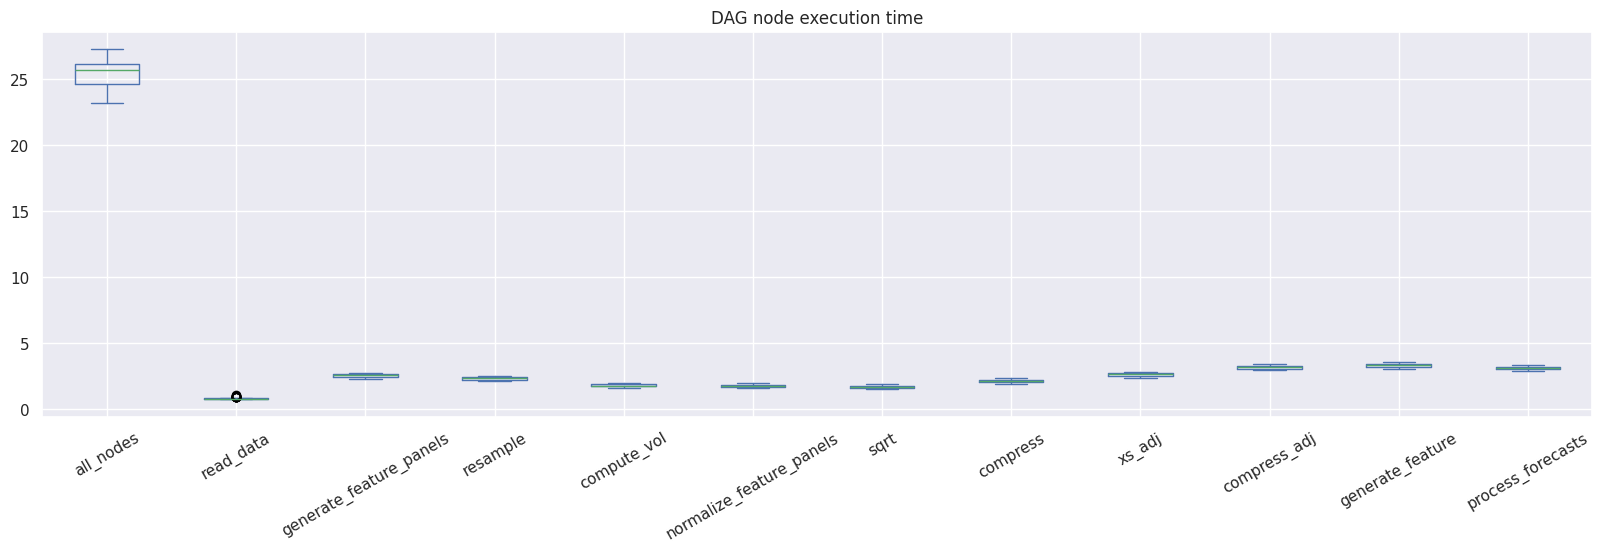

In [22]:
dtfcore.plot_dag_execution_stats(df_dag_execution_time, report_stats=True)

In [23]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = dtfcore.get_orders_execution_time(
    orders_path_dict["prod"]
)
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=41 secs


# Compute DAG memory consumption

In [24]:
# Use a results df's size to measure memory consumption.
dag_df_out_size = dtfcore.get_dag_df_out_size_for_all_nodes(dag_path)
_LOG.info("DAG results df size:")
hpandas.df_to_str(dag_df_out_size, num_rows=5, log_level=logging.INFO)

INFO  DAG results df size:


read_data        generate_feature_panels        resample        compute_vol        normalize_feature_panels          sqrt        compress        xs_adj        compress_adj        generate_feature        process_forecasts       
                             n_cols n_rows                  n_cols n_rows   n_cols n_rows      n_cols n_rows                   n_cols n_rows n_cols n_rows   n_cols n_rows n_cols n_rows       n_cols n_rows           n_cols n_rows            n_cols n_rows
2024-01-12 08:30:00-05:00       240     31                     816     31      744      2         816      2                      744      2    816      2     1176      2   1536      2         1896      2             1920      2              1920      2
2024-01-12 09:00:00-05:00       240     31                     816     31      744      2         816      2                      744      2    816      2     1176      2   1536      2         1896      2             1920      2              1920      2
                                ...    ...                     ...    ...      ...    ...         ...    ...                      ...    ...    ...    ...      ...    ...    ...    ...          ...    ...              ...    ...               ...    ...
2024-01-13 07:30:00-05:00       240     31                     816     31      744      2         816      2                      744      2    816      2     1176      2   1536      2         1896      2             1920      2              1920      2
2024-01-13 08:00:00-05:00       240     31                     816     31      744      2         816      2                      744      2    816      2     1176      2   1536      2         1896      2             1920      2              1920      2

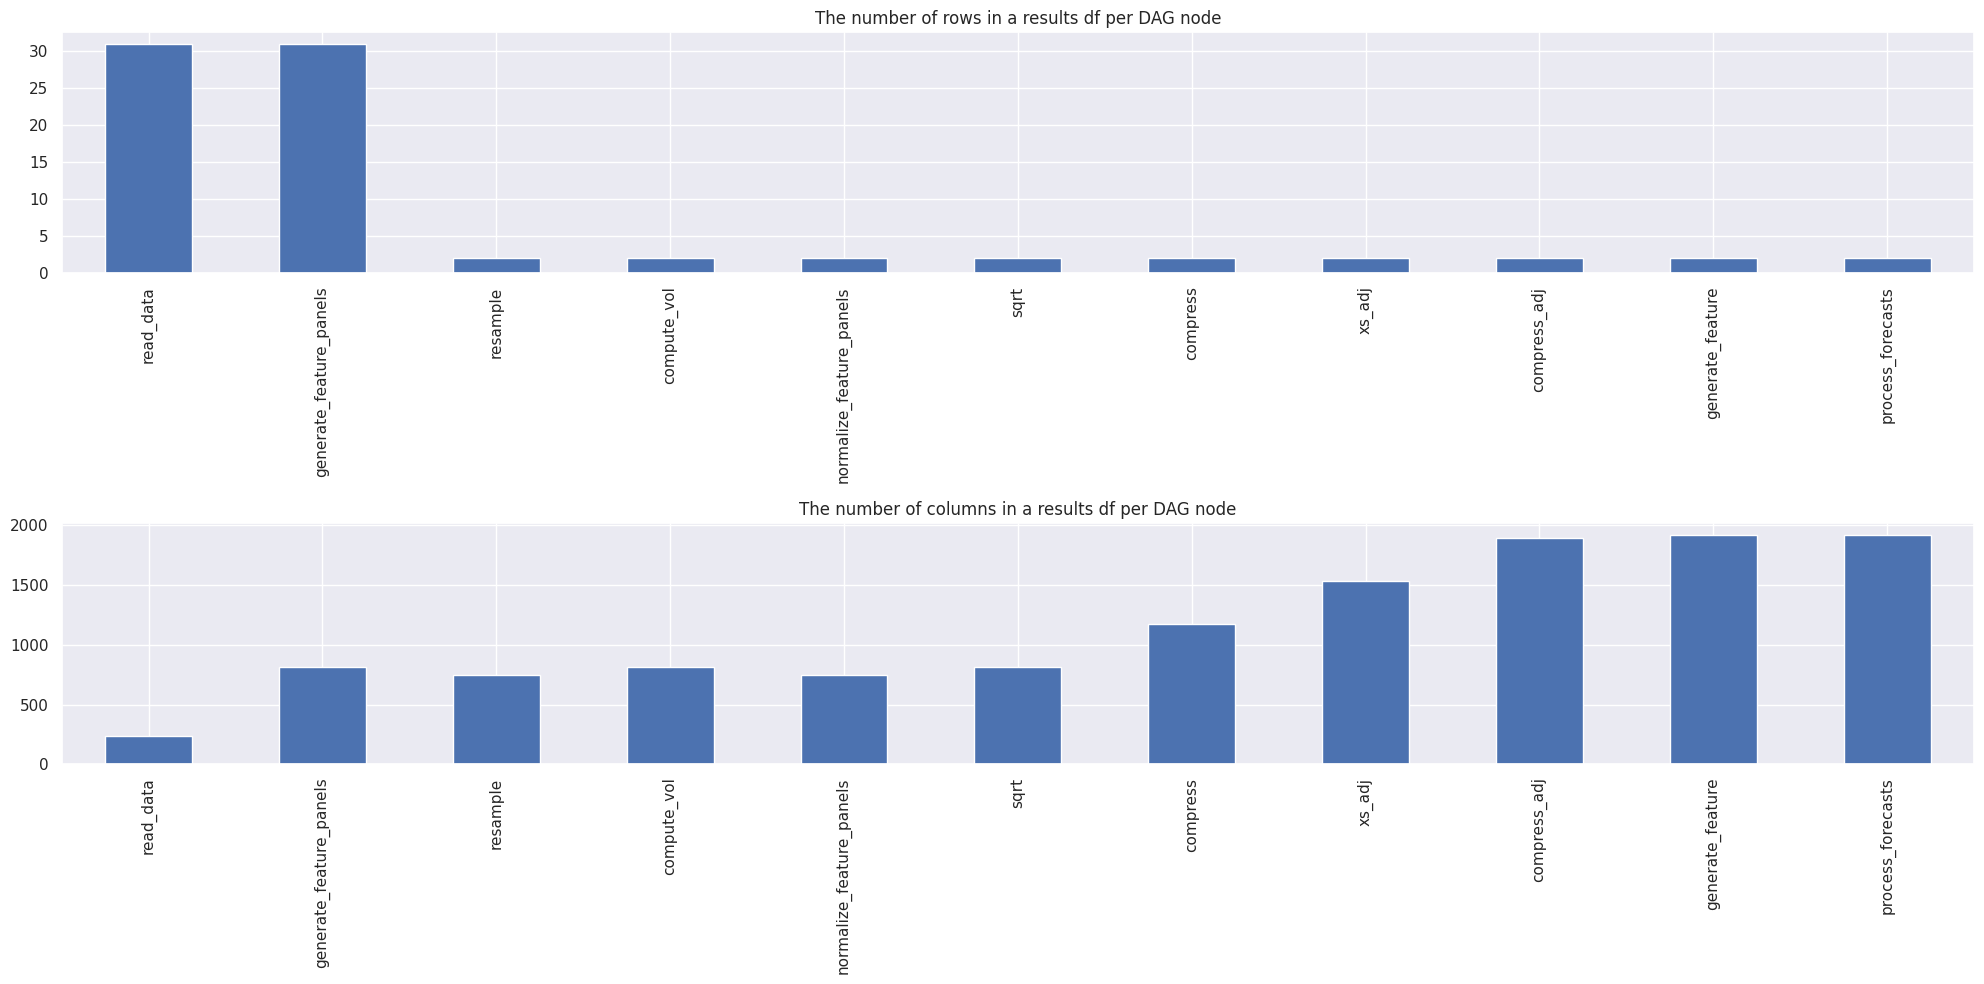

In [25]:
# Display the results df size distribution over the DAG nodes.
dtfcore.plot_dag_df_out_size_stats(dag_df_out_size, report_stats=False)

# Portfolio

## Compute research portfolio equivalent

In [26]:
# Set Portofolio start and end timestamps.
if True:
    # By default use the min/max bar timestamps from the DAG.
    start_timestamp = dag_node_timestamps[0][0]
    end_timestamp = dag_node_timestamps[-1][0]
else:
    # Overwrite if needed.
    start_timestamp = pd.Timestamp(
        "2022-11-03 06:05:00-04:00", tz="America/New_York"
    )
    end_timestamp = pd.Timestamp(
        "2022-11-03 08:00:00-04:00", tz="America/New_York"
    )
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-01-12 08:30:00-05:00
INFO  end_timestamp=2024-01-13 08:00:00-05:00


In [27]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["research_forecast_evaluator_from_prices"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
].to_dict()
# Get dag data path for research portfolio.
compute_research_portfolio_mode = config["meta"][
    "compute_research_portfolio_mode"
]
computation_dag_path = reconcil.get_dag_output_path(
    dag_path_dict, compute_research_portfolio_mode
)
# Get computation dataframe for research portfolio.
research_portfolio_input_df = dtfcore.load_dag_outputs(
    computation_dag_path, dag_node_names[-1]
)
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    research_portfolio_input_df,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod and sim portfolios.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1001) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2024-01-12 10:00:00-05:00,-7.32688,2898.16918,778.92908,3002.69396,1063.6115,24.0,0.0,0.0
2024-01-12 10:30:00-05:00,-9.80979,3757.41461,-831.69091,2972.0292,222.1108,24.0,0.0,0.0
,...,...,...,...,...,...,...,...
2024-01-13 07:30:00-05:00,0.68137,4051.04022,285.25418,3037.16535,-241.67451,24.0,0.0,2.0
2024-01-13 08:00:00-05:00,-1.58023,3195.51843,-671.56625,3016.92651,-914.82099,24.0,0.0,2.0


## Load logged portfolios (prod & sim)

In [28]:
portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    portfolio_path_dict,
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240112_133000.20240113_130000/simulation/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                              holdings_notional                                                                                                                                                                                                                                                                                                                         executed_trades_shares                                                                                                                                                                                                                                                              executed_trades_notional                                                                                                                                                                                                                                                                                                                                    pnl                                                                                                                                                                                                                                                               
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978    1464553467   1467591036    1528092593    1776791608   1891737434   1966583502    2099673105    2237530510    2384892553    2425308589    2484635488    2540896331    2601760471   2683705052    3065029174   3401245610   4516629366   5115052901    5118394986    6051632686 8717633868    8968126878    9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686    8717633868    2540896331    1528092593    8968126878   1467591036    5115052901    3065029174   1891737434    3401245610    1464553467   1966583502    1030828978    2601760471   2683705052    9872743573    2484635488    2099673105  4516629366    2237530510    2425308589   1776791608    2384892553    5118394986  1030828978 1464553467 1467591036 1528092593  1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488  2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2024-01-12 08:30:00-05:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0           0.0          0.0           0.0           0.0          0.0          0.0           0.0           0.0           0.0           0.0           0.0           0.0           0.0          0.0           0.0          0.0          0.0          0.0           0.0           0.0        0.0           0.0           0.0                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN           NaN           NaN           NaN           NaN          NaN           NaN  

In [29]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                                          sim                                                                                                  research                                                               
                                  pnl   gross_volume    net_volume            gmv           nmv          cash  net_wealth     leverage         pnl   gross_volume    net_volume            gmv           nmv          cash  net_wealth     leverage      pnl gross_volume net_volume         gmv        nmv   gpc  npc  wnl
2024-01-12 08:30:00-05:00         NaN            0.0           0.0            0.0           0.0         700.0       700.0          0.0         NaN            0.0           0.0            0.0           0.0         700.0       700.0          0.0      NaN          NaN        NaN         NaN        NaN   NaN  NaN  NaN
2024-01-12 09:00:00-05:00         0.0  199758.941369  35002.275738  199758.941369  35002.275738 -34302.275738       700.0   285.369916         0.0  199758.941369  35002.275738  199758.941369  35002.275738 -34302.275738       700.0   285.369916      NaN          NaN        NaN         NaN        NaN   NaN  NaN  NaN
                                  ...            ...           ...            ...           ...           ...         ...          ...         ...            ...           ...            ...           ...           ...         ...          ...      ...          ...        ...         ...        ...   ...  ...  ...
2024-01-13 07:30:00-05:00  109.290469  574636.327555  50554.599742  328978.426161 -23662.236108  24020.243189  358.007081   918.915977  109.290469  574636.327555  50554.599742  328978.426161 -23662.236108  24020.243189  358.007081   918.915977  0.68137   4051.04022  285.25418  3037.16535 -241.67451  24.0  0.0  2.0
2024-01-13 08:00:00-05:00   -9.616861  413791.488264 -54826.785626  381226.632583 -78498.638595  78847.028815   348.39022  1094.251822   -9.616861  413791.488264 -54826.785626  381226.632583 -78498.638595  78847.028815   348.39022  1094.251822 -1.58023   3195.51843 -671.56625  3016.92651 -914.82099  24.0  0.0  2.0

## Compute Portfolio statistics (prod vs research vs sim)

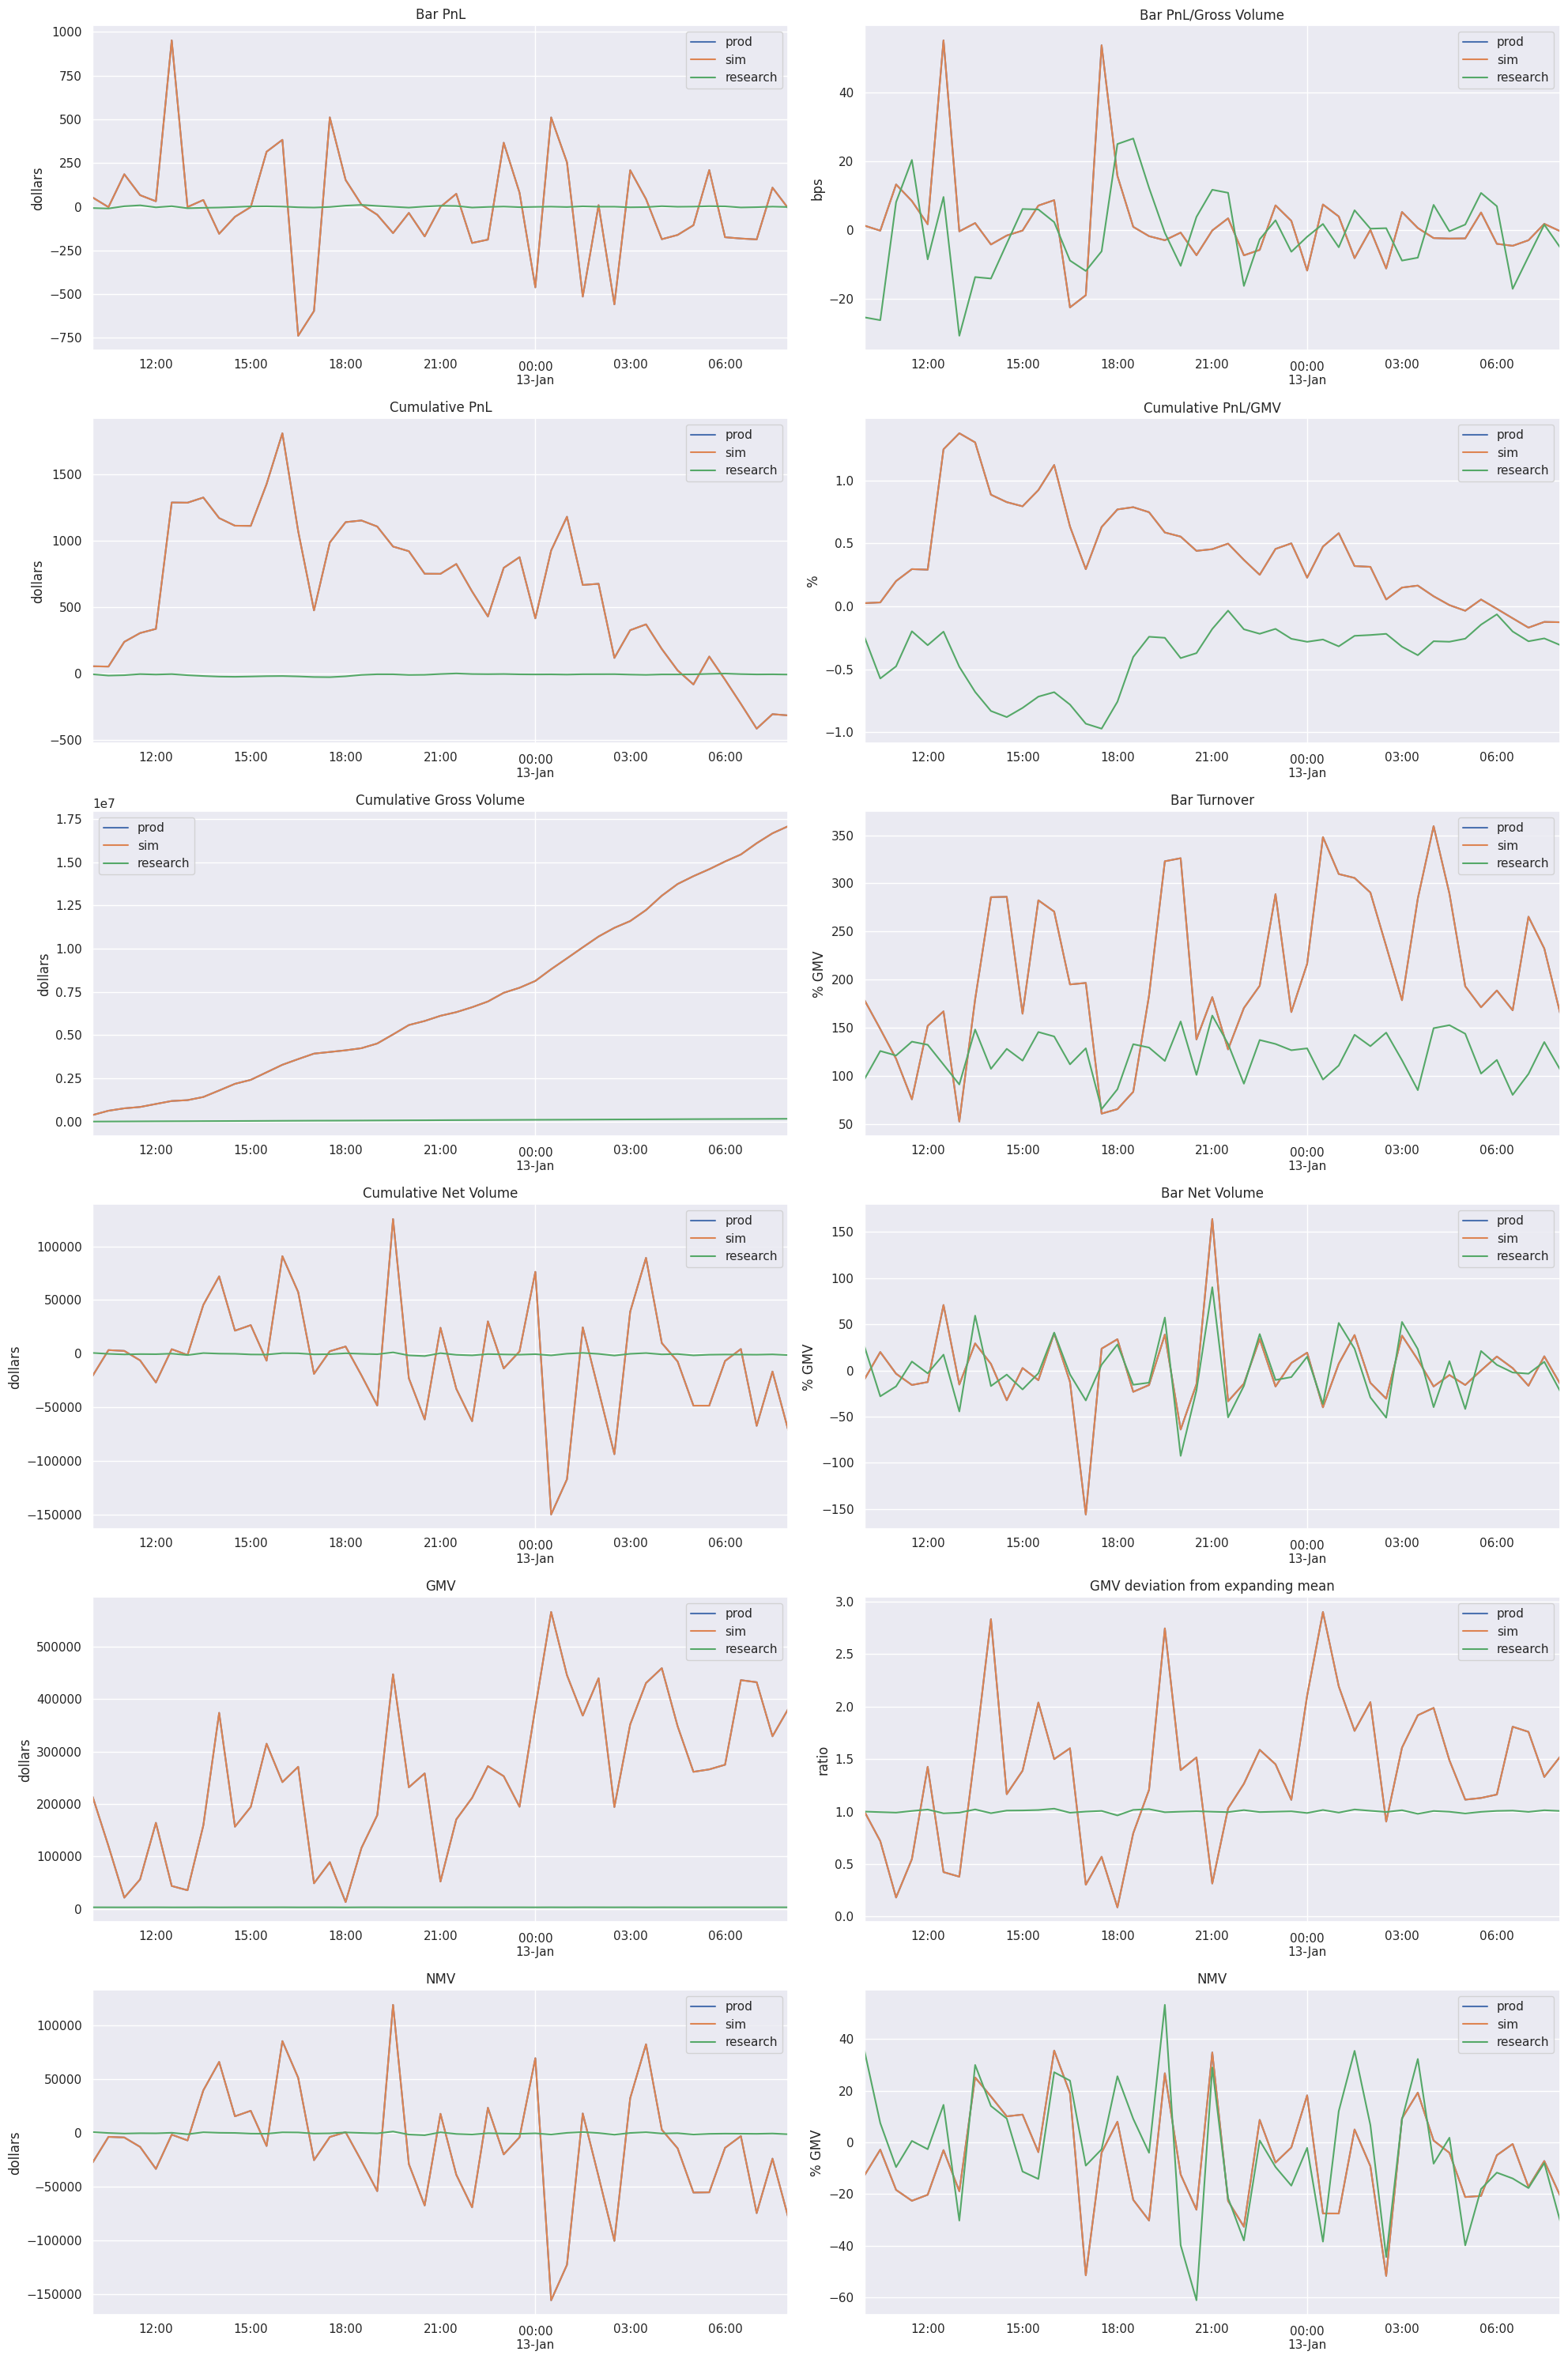

In [30]:
bars_to_burn = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
]["burn_in_bars"]
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [31]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod        sim  research
ratios     sharpe_ratio                     -3.07      -3.07     -6.47
           sharpe_ratio_standard_error      19.96      19.96     19.97
           sr.tval                          -0.16      -0.16     -0.33
           sr.pval                           0.88       0.88      0.74
           kratio                          -12.82     -12.82     11.52
dollar     gmv_mean                     250377.99  250377.99   2999.29
           gmv_stdev                    141154.16  141154.16     41.32
           annualized_mean_return      -123517.81 -123517.81  -3596.60
           annualized_volatility         40252.85   40252.85    556.24
           max_drawdown                   2224.01    2224.01     23.22
           pnl_mean                         -7.05      -7.05     -0.21
           pnl_std                         304.06     304.06      4.20
           turnover_mean                379822.72  379822.72   3629.28
           turnover_stdev               189929.30  189929.30    667.44
           market_bias_mean             -11585.65  -11585.65    -84.16
           market_bias_stdev             53711.05   53711.05    737.99
percentage annualized_mean_return          -49.33     -49.33   -119.91
           annualized_volatility            16.08      16.08     18.55
           max_drawdown                      0.89       0.89      0.77
           pnl_mean                         -0.00      -0.00     -0.01
           pnl_std                           0.12       0.12      0.14
           turnover_mean                   151.70     151.70    121.00
           turnover_stdev                   75.86      75.86     22.25
           market_bias_mean                 -4.63      -4.63     -2.81
           market_bias_stdev                21.45      21.45     24.61

## Compare portfolios pairwise (prod vs research vs sim)

### Differences

#### Prod vs sim

In [32]:
report_stats = False
display_plot = False
compare_dfs_kwargs = {
    "column_mode": "inner",
    "diff_mode": "pct_change",
    "remove_inf": True,
    "assert_diff_threshold": None,
}
portfolio_diff_df = reconcil.compare_portfolios(
    portfolio_dfs,
    report_stats=report_stats,
    display_plot=display_plot,
    **compare_dfs_kwargs,
)
hpandas.df_to_str(portfolio_diff_df, num_rows=None, log_level=logging.INFO)

,prod_research_diff,prod_sim_diff,research_sim_diff
executed_trades_notional.pct_change,4.444726e+06,0.0,143.271167
executed_trades_shares.pct_change,4.480800e+06,0.0,143.057996
holdings_notional.pct_change,1.221336e+05,0.0,100.703057
holdings_shares.pct_change,1.217125e+05,0.0,100.704225
pnl.pct_change,6.848513e+06,0.0,257.290871


### Correlations

#### Prod vs sim

In [33]:
if False:
    dtfmod.compute_correlations(
        portfolio_dfs["prod"],
        portfolio_dfs["sim"],
        allow_unequal_indices=False,
        allow_unequal_columns=False,
    )

#### Prod vs research

In [34]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["prod"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

#### Sim vs research

In [35]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["sim"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

# Target positions

## Load target positions (prod)

In [36]:
prod_target_position_df = reconcil.load_target_positions(
    portfolio_path_dict["prod"].strip("portfolio"),
    config["meta"]["bar_duration"],
)
hpandas.df_to_str(prod_target_position_df, num_rows=5, log_level=logging.INFO)
if False:
    # TODO(Grisha): compare prod vs sim at some point.
    sim_target_position_df = reconcil.load_target_positions(
        portfolio_path_dict["sim"].strip("portfolio"),
        config["meta"]["bar_duration"],
    )

Loading `target_positions` files...:   0%|          | 0/48 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                   price                                                                                                                                                                                                                                                                    holdings_notional                                                                                                                                                                                                                                                                                                                         prediction                                                                                                                                                                                                                                                              volatility                                                                                                                                                                                                                                                                  spread                                                                                                                                                                                                                                                              target_holdings_notional                                                                                                                                                                                                                                                                                                                        target_trades_notional                                                                                                                                                                                                                                                                                                                            target_trades_shares                                                                                                                                                                                                                                                              target_holdings_shares                                                                                                                                                                                                                                                              target_holdings_shares.before_apply_cc_limits                                                                                                                                                                                                                                                              target_holdings_notional.before_apply_cc_limits                                                                                                                                                                                                                                                                                                                        target_trades_shares.before_apply_cc_limits                                                                                                                                                                                                                                                              target_trades_notional.before_apply_cc_limits                                                                                                                   

## Compare positions target vs executed (prod)

In [37]:
# TODO(Grisha): use `hpandas.compare_dfs()`.
df1 = prod_target_position_df["target_holdings_shares"].shift(1)
df2 = prod_target_position_df["holdings_shares"]
diff = df1 - df2
hpandas.df_to_str(diff, num_rows=5, log_level=logging.INFO)

asset_id,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2024-01-12 08:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12 09:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-13 07:30:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-13 08:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare target positions (prod vs research)

### Price

In [38]:
# TODO(Grisha): wrap in a function since it's common for all columns.
column = "price"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    # Some pipelines (e.g., "C8b") do not use "close" prices to compute
    # "twap" / "vwap". While when computing target positions "close"
    # prices from MarketData are used. Thus the perfect match is not
    # expected.
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

2.8396666630854543


### Volatility

In [39]:
column = "volatility"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

5.154354979592612e-12


### Prediction

In [40]:
column = "prediction"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

8.131611709121455e-12


### Current holdings

In [41]:
column = "holdings_shares"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

121712.5


### Target holdings

In [42]:
prod_df = prod_target_position_df["target_holdings_shares"].shift(1)
res_df = research_portfolio_df["holdings_shares"]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

121712.5


# Orders

## Load orders (prod & sim)

In [43]:
prod_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["prod"].strip("portfolio"),
)
hpandas.df_to_str(prod_order_df, num_rows=5, log_level=logging.INFO)
sim_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["sim"].strip("portfolio"),
)
hpandas.df_to_str(sim_order_df, num_rows=5, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/48 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2024-01-12 08:30:39.508963-05:00,6051632686,price@twap,2024-01-12 08:30:39.508963-05:00,2024-01-12 09:00:00-05:00,0.0,-7391.0,America/New_York,{}
1,2024-01-12 08:30:39.508963-05:00,8717633868,price@twap,2024-01-12 08:30:39.508963-05:00,2024-01-12 09:00:00-05:00,0.0,480.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
916,2024-01-13 08:00:41.246719-05:00,8968126878,price@twap,2024-01-13 08:00:41.246719-05:00,2024-01-13 08:30:00-05:00,-136.51,136.51,America/New_York,{}
917,2024-01-13 08:00:41.246719-05:00,9872743573,price@twap,2024-01-13 08:00:41.246719-05:00,2024-01-13 08:30:00-05:00,3832.0,-10722.0,America/New_York,{}


Loading `orders` files...:   0%|          | 0/48 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2024-01-12 08:30:11-05:00,6051632686,price@twap,2024-01-12 08:30:11-05:00,2024-01-12 09:00:00-05:00,0.0,-7391.0,America/New_York,{}
1,2024-01-12 08:30:11-05:00,8717633868,price@twap,2024-01-12 08:30:11-05:00,2024-01-12 09:00:00-05:00,0.0,480.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
916,2024-01-13 08:00:11-05:00,8968126878,price@twap,2024-01-13 08:00:11-05:00,2024-01-13 08:30:00-05:00,-136.51,136.51,America/New_York,{}
917,2024-01-13 08:00:11-05:00,9872743573,price@twap,2024-01-13 08:00:11-05:00,2024-01-13 08:30:00-05:00,3832.0,-10722.0,America/New_York,{}


## Compare orders (prod vs sim)

In [44]:
# TODO(Grisha): add comparison using the usual `pct_change` approach.

# Compute execution quality

In [45]:
(
    execution_quality_df,
    execution_quality_stats_df,
) = cftpdp.compute_execution_quality_df(
    portfolio_dfs["prod"],
    prod_target_position_df,
)
hpandas.df_to_str(execution_quality_df, num_rows=5, log_level=logging.INFO)
hpandas.df_to_str(execution_quality_stats_df, num_rows=5, log_level=logging.INFO)

executed_trades_shares                                                                                                                                                                                                                                                               fill_rate                                                                                                                                                                                                                                                              underfill_share_count                                                                                                                                                                                                                                                              underfill_notional                                                                                                                                                                                                                                                              underfill_opportunity_cost_realized_notional                                                                                                                                                                                                                                                              underfill_opportunity_cost_notional                                                                                                                                                                                                                                                              tracking_error_shares                                                                                                                                                                                                                                                              tracking_error_notional                                                                                                                                                                                                                                                               tracking_error_bps                                                                                                                                                                                                                                                                   is_buy                                                                                                                                                                                                                                                                 is_sell                                                                                                                                                                                                                                                              is_benchmark_profitable                                                                                                                                                                                                                                                              holdings_price_per_share                                                                                                                                                                                                                                                                    trade_price_per_share                                                                                                                                                                                                                                                                    slippage_notional                                                                                                                 

,slippage_notional,underfill_opportunity_cost_realized_notional,pnl,gross_volume,net_volume,gmv,nmv
2024-01-12 08:30:00-05:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-01-12 09:00:00-05:00,0.0,NaN,0.0,199758.941369,35002.275738,199758.941369,35002.275738
,...,...,...,...,...,...,...
2024-01-13 07:30:00-05:00,-0.0,-0.0,109.290469,574636.327555,50554.599742,328978.426161,-23662.236108
2024-01-13 08:00:00-05:00,0.0,-0.0,-9.616861,413791.488264,-54826.785626,381226.632583,-78498.638595


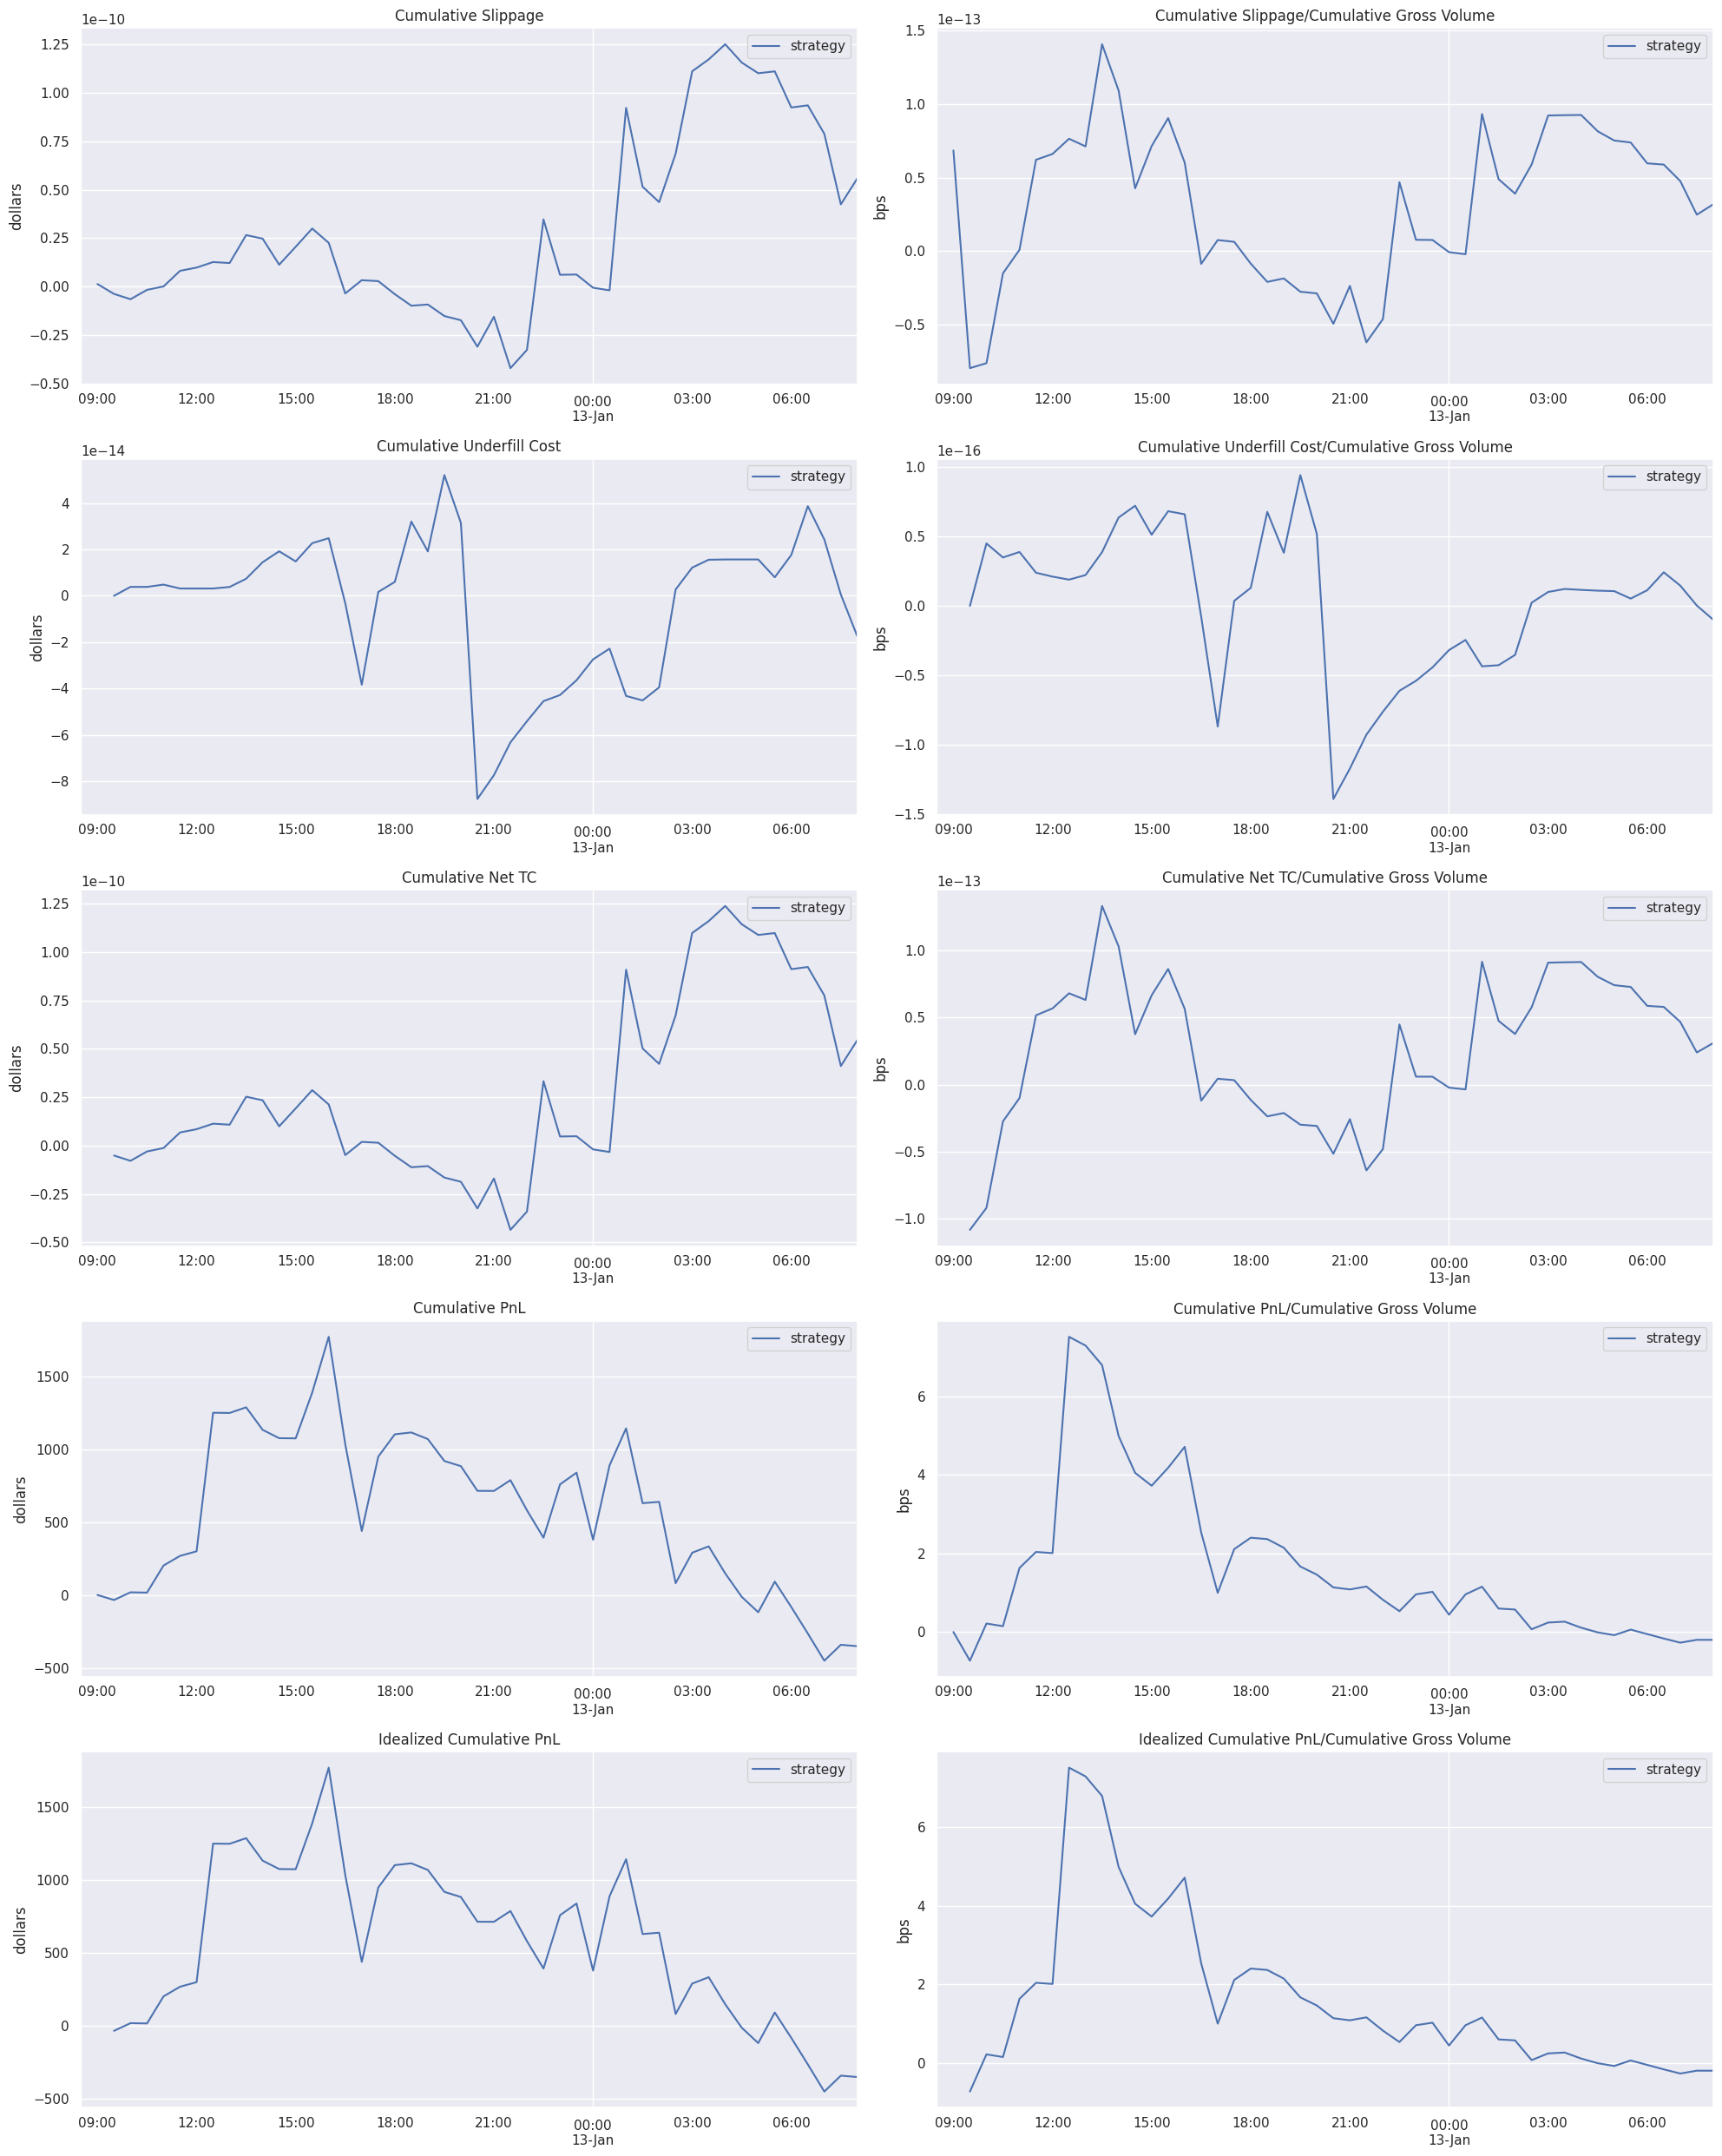

In [46]:
coplotti.plot_execution_stats(execution_quality_stats_df)

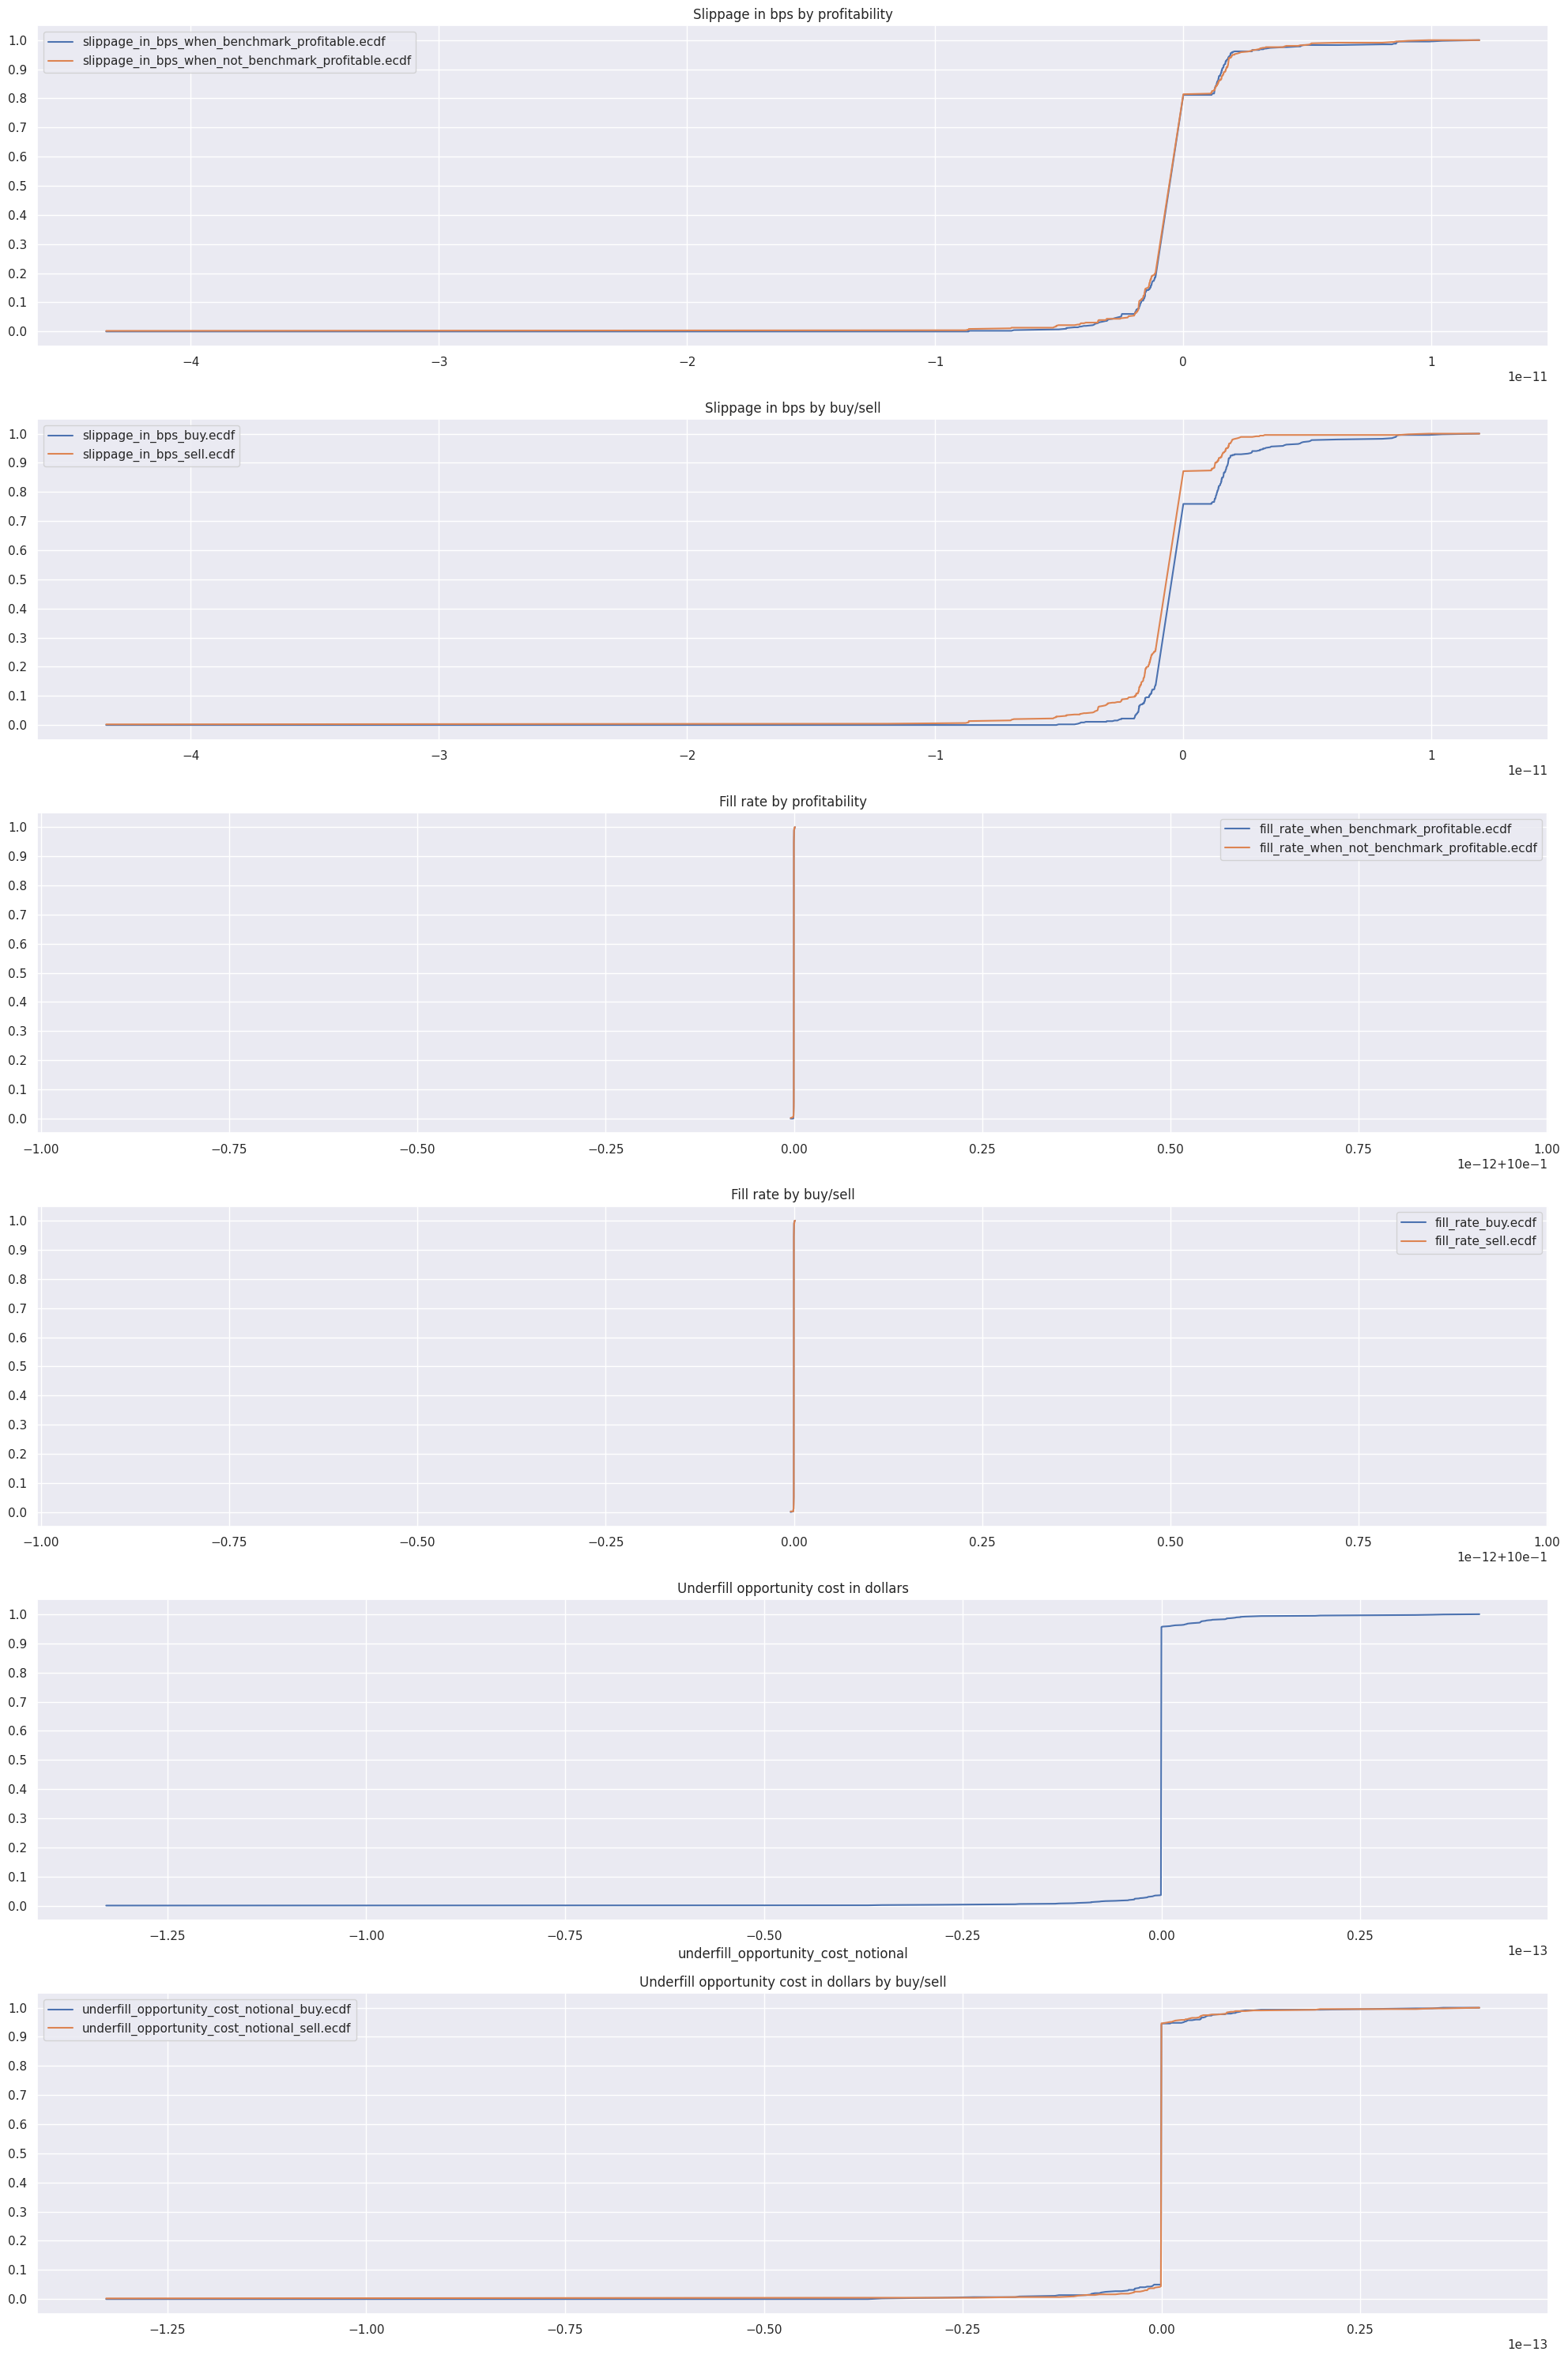

In [47]:
coplotti.plot_execution_ecdfs(execution_quality_df)